In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import os

os.makedirs("new_figures/dl_biomarkers", exist_ok=True)

# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data
adata = sc.read_h5ad('lee2020_processed.h5ad')
adata.obs['label'] = (adata.obs['CONDITION'] == 'Tumor').astype(int)

X = pd.DataFrame(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X,
                 columns=adata.var_names)

y = adata.obs['label'].values

# Features (HVG + top DE)
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
hvg = adata.var_names[adata.var['highly_variable']]
top_de = ['CEACAM5','CEACAM6','TFF3','LCN2','AGR2','EPCAM','S100P','CXCL8',
          'KRT18','CLDN4','MAL2','GDF15','KRT19','RAB25','ELF3','GPX2']
features = list(set(hvg.tolist() + top_de))
features = [g for g in features if g in X.columns]

X_dl = X[features].values.astype(np.float32)  # numpy array for torch

# Normalize (mean 0, std 1 per gene)
X_dl = (X_dl - X_dl.mean(axis=0)) / (X_dl.std(axis=0) + 1e-8)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_dl, y, test_size=0.25, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Using device: cuda


In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import os

os.makedirs("new_figures/dl_biomarkers_cpu", exist_ok=True)

# Force CPU (no GPU)
device = torch.device("cpu")
print("Using CPU only for training")

# Load data
adata = sc.read_h5ad('lee2020_processed.h5ad')
adata.obs['label'] = (adata.obs['CONDITION'] == 'Tumor').astype(int)

# X = expression (float32 for torch)
X = pd.DataFrame(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X,
                 columns=adata.var_names).astype(np.float32)

y = adata.obs['label'].values

# Features: HVG + top DE (fast & effective)
sc.pp.highly_variable_genes(adata, n_top_genes=800)  # কম genes = faster training
hvg = adata.var_names[adata.var['highly_variable']]
top_de = ['CEACAM5','CEACAM6','TFF3','LCN2','AGR2','EPCAM','S100P','CXCL8',
          'KRT18','CLDN4','MAL2','GDF15','KRT19','RAB25','ELF3','GPX2']
features = list(set(hvg.tolist() + top_de))
features = [g for g in features if g in X.columns]

X_dl = X[features].values

# Normalize per gene
X_dl = (X_dl - X_dl.mean(axis=0)) / (X_dl.std(axis=0) + 1e-8)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_dl, y, test_size=0.25, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Using CPU only for training
Train shape: (46027, 805) Test shape: (15343, 805)


In [2]:
class SimpleCRCNNet(nn.Module):
    def __init__(self, input_size):
        super(SimpleCRCNNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)   # ছোট layer
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# Model + loss + optimizer (CPU friendly)
input_dim = X_train.shape[1]
model = SimpleCRCNNet(input_dim).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # small lr

# DataLoader (small batch = CPU-এ fast)
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
test_dataset  = TensorDataset(torch.tensor(X_test), torch.tensor(y_test, dtype=torch.float32).unsqueeze(1))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)   # ছোট batch
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

Epoch 5/30 - Loss: 0.0295 - Val Accuracy: 0.9376
Epoch 10/30 - Loss: 0.0103 - Val Accuracy: 0.9371
Epoch 15/30 - Loss: 0.0105 - Val Accuracy: 0.9369
Epoch 20/30 - Loss: 0.0092 - Val Accuracy: 0.9370
Epoch 25/30 - Loss: 0.0065 - Val Accuracy: 0.9374
Epoch 30/30 - Loss: 0.0064 - Val Accuracy: 0.9369

Simple Neural Network (CPU) Results:
Final Accuracy: 0.9369
AUC-ROC: 0.9711

Classification Report:
               precision    recall  f1-score   support

      Normal       0.89      0.86      0.87      3912
       Tumor       0.95      0.96      0.96     11431

    accuracy                           0.94     15343
   macro avg       0.92      0.91      0.92     15343
weighted avg       0.94      0.94      0.94     15343



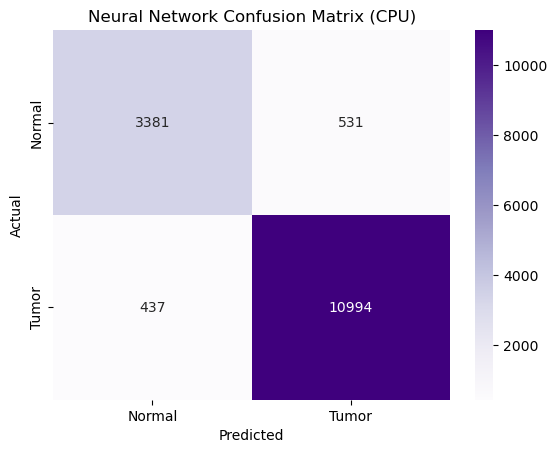

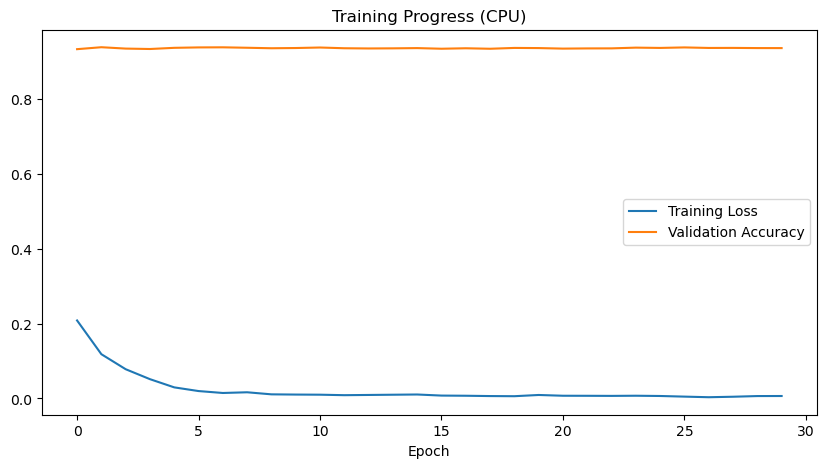

In [3]:
epochs = 30  # কম epochs = fast training
train_losses = []
val_accuracies = []

model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    # Validation accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.cpu() == labels.cpu()).sum().item()
    
    val_acc = correct / total
    val_accuracies.append(val_acc)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Val Accuracy: {val_acc:.4f}")

# Final evaluation
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test).to(device)
    y_prob_dl = model(X_test_tensor).cpu().numpy().flatten()
    y_pred_dl = (y_prob_dl > 0.5).astype(int)

acc_dl = accuracy_score(y_test, y_pred_dl)
auc_dl = roc_auc_score(y_test, y_prob_dl)

print("\nSimple Neural Network (CPU) Results:")
print(f"Final Accuracy: {acc_dl:.4f}")
print(f"AUC-ROC: {auc_dl:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_dl, target_names=['Normal', 'Tumor']))

# Confusion Matrix
cm_dl = confusion_matrix(y_test, y_pred_dl)
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Purples', xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'])
plt.title('Neural Network Confusion Matrix (CPU)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("new_figures/dl_biomarkers_cpu/nn_confusion_matrix.png", dpi=300)
plt.show()

# Training curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training Progress (CPU)')
plt.xlabel('Epoch')
plt.legend()
plt.savefig("new_figures/dl_biomarkers_cpu/training_curve.png", dpi=300)
plt.show()

Calculating permutation importance... (may take 5-20 mins on CPU)


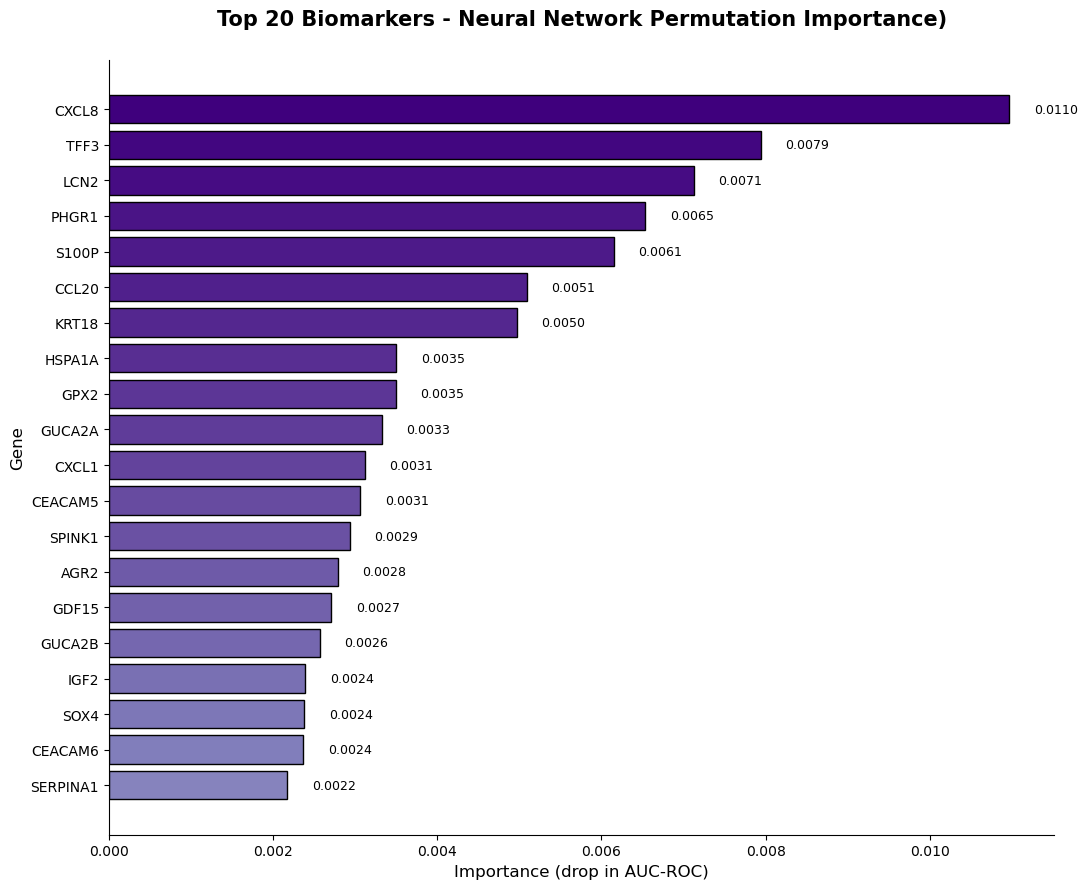

Top 10 DL Identified Biomarkers (custom permutation):
       gene  importance
84    CXCL8    0.010968
391    TFF3    0.007941
701    LCN2    0.007124
548   PHGR1    0.006535
596   S100P    0.006149
10    CCL20    0.005090
83    KRT18    0.004968
676  HSPA1A    0.003504
631    GPX2    0.003497
372  GUCA2A    0.003323


In [7]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Custom permutation importance function (sklearn-এর উপর depend না করে)
def custom_permutation_importance(model, X, y, n_repeats=5, random_state=42):
    np.random.seed(random_state)
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        baseline_prob = model(X_tensor).cpu().numpy().flatten()
        baseline_auc = roc_auc_score(y, baseline_prob)
    
    importances = np.zeros(X.shape[1])
    
    for col in range(X.shape[1]):
        X_perm = X.copy()
        scores = []
        for _ in range(n_repeats):
            np.random.shuffle(X_perm[:, col])  # shuffle this column
            with torch.no_grad():
                X_perm_tensor = torch.tensor(X_perm, dtype=torch.float32).to(device)
                prob = model(X_perm_tensor).cpu().numpy().flatten()
                scores.append(roc_auc_score(y, prob))
        importances[col] = baseline_auc - np.mean(scores)  # drop in AUC = importance
    
    return importances

# Run custom importance (slow হতে পারে, n_repeats কম রাখো)
print("Calculating permutation importance... (may take 5-20 mins on CPU)")
perm_importances = custom_permutation_importance(model, X_test, y_test, n_repeats=3)

# Top 20
perm_df = pd.DataFrame({
    'gene': features,
    'importance': perm_importances
}).sort_values('importance', ascending=False).head(20)

# Traditional Bar Plot
fig, ax = plt.subplots(figsize=(11, 9))
colors = plt.cm.Purples(np.linspace(0.6, 1.0, 20))
bars = ax.barh(perm_df['gene'][::-1], perm_df['importance'][::-1], color=colors, edgecolor='black')

ax.set_title(f'Top 20 Biomarkers - Neural Network Permutation Importance)', 
             fontsize=15, fontweight='bold', pad=25)
ax.set_xlabel('Importance (drop in AUC-ROC)', fontsize=12)
ax.set_ylabel('Gene', fontsize=12)

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.0003, bar.get_y() + bar.get_height()/2,
            f'{width:.4f}', va='center', fontsize=9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("new_figures/dl_biomarkers_cpu/nn_top20_biomarkers_custom.png", dpi=400, bbox_inches='tight')
plt.show()

print("Top 10 DL Identified Biomarkers (custom permutation):")
print(perm_df.head(10))